## Практическое задание 6. Градиентный бустинг ~~своими руками~~

Поздравляю! Это финальное упражнение в нашем курсе. Проявите все своё старание, терпение и опыт, чтобы выполнить его.  
Теперь вы многое знаете из машинного обучения и для вас не составит сложности попробовать разные алгоритмы, новые библиотеки и применить их к реальной задаче.

__Задание 1. (0.5 балла)__

Мы будем использовать данные соревнования [Home Credit Default Risk](https://www.kaggle.com/c/home-credit-default-risk/data).  

* Загрузите таблицу **application_train.csv**;
* Запишите в Y столбец с целевой переменной;
* Удалите ненужные столбцы (для этого воспользуйтесь описанием);
* Определите тип столбцов и заполните пропуски - стратегия произвольная;
* Разбейте выборку в соотношении 70:30 с random_state=0.

Так как в данных значительный дисбаланс классов, в качестве метрики качества везде будем использовать площадь под precision-recall кривой.

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Загрузка данных из файла 'application_train.csv'
data = pd.read_csv('application_train.csv')

# Выделение целевой переменной
Y = data['TARGET']
#Удаление ненужных столбцов
unnecessary_columns = ['OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 
                   'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE']

data.drop(columns=unnecessary_columns, inplace=True)

# Заполнение пропущенных значений часто встречающимися значениями (модой) для каждого столбца
data.fillna(data.mode().iloc[0], inplace=True)

# Разделение данных на обучающий и тестовый наборы
# 70% данных используются для обучения, 30% - для тестирования. random_state=0 обеспечивает воспроизводимость результатов
X_train, X_test, Y_train, Y_test = train_test_split(data, Y, test_size=0.3, random_state=0)



In [3]:
from sklearn.model_selection import train_test_split

# Разделение выборки на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(data, Y, test_size=0.3, random_state=0)

# Проверка размерности полученных наборов
print("Размерность обучающего набора:", X_train.shape, y_train.shape)
print("Размерность тестового набора:", X_test.shape, y_test.shape)


Размерность обучающего набора: (215257, 117) (215257,)
Размерность тестового набора: (92254, 117) (92254,)


__Задание 2. (1.5 балла)__

Также мы будем использовать две реализации градиентного бустинга: [LightGBM](https://lightgbm.readthedocs.io/en/stable/Python-API.html) и [Catboost](https://catboost.ai/en/docs/), которые вам необходимо самостоятельно изучить и установить, используя команды:  
`!pip install lightgb`  
`!pip install catboost`  
Обучите реализации градиентного бустинга LightGBM и Catboost на вещественных признаках без подбора параметров. 
Почему получилась заметная разница в качестве? 

В этом и последующих экспериментах необходимо измерять время обучения моделей.

In [18]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Загрузим данные
data = pd.read_csv('application_train.csv')

# Выберем только вещественные признаки (числовые)
numeric_features = data.select_dtypes(include=[np.number])

# Запишем целевую переменную
Y = numeric_features['TARGET']

# Удалим ненужные столбцы (ID)
X = numeric_features.drop(['TARGET', 'SK_ID_CURR'], axis=1)

# Заполним пропущенные значения средними
X = X.fillna(X.mean())

# Разделим данные на обучающий и тестовый наборы
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)


In [19]:
# Обучение модели LightGBM
lgbm_model = LGBMClassifier(random_state=42)
lgbm_model.fit(X_train, Y_train)

# Обучение модели CatBoost
catboost_model = CatBoostClassifier(random_state=42, verbose=0)
catboost_model.fit(X_train, Y_train)

# Получим предсказания на тестовом наборе
lgbm_preds = lgbm_model.predict_proba(X_test)[:, 1]
catboost_preds = catboost_model.predict_proba(X_test)[:, 1]

# Вычисление метрики AUC-PR для LightGBM
lgbm_auc_pr = average_precision_score(Y_test, lgbm_preds)

# Вычисление метрики AUC-PR для CatBoost
catboost_auc_pr = average_precision_score(Y_test, catboost_preds)

print(f'AUC-PR для LightGBM: {lgbm_auc_pr:.4f}')
print(f'AUC-PR для CatBoost: {catboost_auc_pr:.4f}')


[LightGBM] [Info] Number of positive: 17485, number of negative: 197772
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.060083 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11059
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081228 -> initscore=-2.425771
[LightGBM] [Info] Start training from score -2.425771
AUC-PR для LightGBM: 0.2287
AUC-PR для CatBoost: 0.2307


Разница в качестве между LightGBM и CatBoost может быть обусловлена несколькими факторами:

1. **Алгоритмы оптимизации:** LightGBM и CatBoost используют разные методы для оптимизации функции потерь. LightGBM использует градиентный спуск на гистограммах для быстрого вычисления градиентов и выбора оптимального разбиения, в то время как CatBoost использует обучение на деревьях решений с симметричным градиентным бустингом.

2. **Обработка категориальных признаков:** CatBoost умеет обрабатывать категориальные признаки "из коробки", что может быть полезным, если в ваших данных присутствуют категориальные признаки. LightGBM также поддерживает категориальные признаки, но требует их предварительного преобразования.

3. **Различия в параметрах по умолчанию:** Параметры по умолчанию в обоих алгоритмах могут влиять на качество модели. Например, различные значения learning_rate, max_depth и количества деревьев могут привести к различиям в качестве.

4. **Реализация алгоритмов:** Различия в том, как реализованы алгоритмы в библиотеках, могут привести к небольшим различиям в вычислениях и, следовательно, в результатах.

__Задание 3. (2 балла)__

Подберите с CV=3 оптимальные параметры алгоритмов, изменяя:

* глубину деревьев;
* количество деревьев;
* темп обучения;
* оптимизируемый функционал.

Проанализируйте соотношения глубины и количества деревьев в зависимости от алгоритма.

In [21]:
from sklearn.model_selection import GridSearchCV

# Параметры для LightGBM
lgbm_params = {
    'n_estimators': [50, 100],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 4],
    'objective': ['binary'],
    'boosting_type': ['gbdt']
}

# Параметры для CatBoost
catboost_params = {
    'iterations': [50, 100],
    'learning_rate': [0.05, 0.1],
    'depth': [3, 4],
    'custom_metric': ['AUC'],
    'verbose': [0],
    'random_state': [42]
}

# Подбор параметров для LightGBM
lgbm_grid = GridSearchCV(LGBMClassifier(random_state=42), lgbm_params, scoring='average_precision', cv=3)
lgbm_grid.fit(X_train, Y_train)

# Подбор параметров для CatBoost
catboost_grid = GridSearchCV(CatBoostClassifier(random_state=42, verbose=0), catboost_params, scoring='average_precision', cv=3)
catboost_grid.fit(X_train, Y_train)

# Вывод оптимальных параметров
print("Оптимальные параметры для LightGBM:", lgbm_grid.best_params_)
print("Оптимальные параметры для CatBoost:", catboost_grid.best_params_)


[LightGBM] [Info] Number of positive: 11656, number of negative: 131848
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030675 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11186
[LightGBM] [Info] Number of data points in the train set: 143504, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081224 -> initscore=-2.425829
[LightGBM] [Info] Start training from score -2.425829
[LightGBM] [Info] Number of positive: 11657, number of negative: 131848
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032778 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11172
[LightGBM] [Info] Number of data points in the train set: 143505, number of used features: 99
[LightGBM] [

__Задание 4. (3.5 балла)__

Добавьте категориальные признаки к вещественным следующими способами:

* как OHE признаки;
* как счетчики со сглаживанием.

При подсчете счетчиков запрещается использование циклов. 

На получившихся датасетах подберите параметры у каждого из алгоритмов. Как меняется время, необходимое для обучения модели в зависимости от способа кодирования? Сравните полученные результаты с встроенными методами обработки категориальных признаков. 

In [12]:
# Преобразование категориальные признаки в числовые с помощью One-Hot Encoding
# Определение категориальных признаков в датасете
categorical_features = data.select_dtypes(include=['object']).columns.tolist()
X_ohe = pd.get_dummies(data, columns=categorical_features)
print(X_ohe)



        SK_ID_CURR  TARGET  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0           100002       1             0          202500.0    406597.5   
1           100003       0             0          270000.0   1293502.5   
2           100004       0             0           67500.0    135000.0   
3           100006       0             0          135000.0    312682.5   
4           100007       0             0          121500.0    513000.0   
...            ...     ...           ...               ...         ...   
307506      456251       0             0          157500.0    254700.0   
307507      456252       0             0           72000.0    269550.0   
307508      456253       0             0          153000.0    677664.0   
307509      456254       1             0          171000.0    370107.0   
307510      456255       0             0          157500.0    675000.0   

        AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0           24700.5         351

__Задание 5. (1 балл)__

Реализуйте блендинг подобранных в предыдущем задании моделей и сравните качество.

In [14]:
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Оптимальные параметры для LightGBM и CatBoost 
lgbm_best_params = {
    'n_estimators': 100,
    'learning_rate': 0.1,
    'max_depth': 4,
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'random_state': 42
}


catboost_best_params = {
    'iterations': 100,
    'learning_rate': 0.1,
    'depth': 4,
    'custom_metric': 'AUC',
    'verbose': 0,
    'random_state': 42
}

# Инициализация и обучение моделей
lgbm_model = LGBMClassifier(**lgbm_best_params)
catboost_model = CatBoostClassifier(**catboost_best_params)

# Обучение моделей
lgbm_model.fit(X_train, Y_train)
catboost_model.fit(X_train, Y_train)

# Получение прогнозов на тестовых данных
lgbm_predictions = lgbm_model.predict_proba(X_test)[:, 1]
catboost_predictions = catboost_model.predict_proba(X_test)[:, 1]


ValueError: pandas dtypes must be int, float or bool.
Fields with bad pandas dtypes: NAME_CONTRACT_TYPE: object, CODE_GENDER: object, FLAG_OWN_CAR: object, FLAG_OWN_REALTY: object, NAME_TYPE_SUITE: object, NAME_INCOME_TYPE: object, NAME_EDUCATION_TYPE: object, NAME_FAMILY_STATUS: object, NAME_HOUSING_TYPE: object, OCCUPATION_TYPE: object, WEEKDAY_APPR_PROCESS_START: object, ORGANIZATION_TYPE: object, FONDKAPREMONT_MODE: object, HOUSETYPE_MODE: object, WALLSMATERIAL_MODE: object, EMERGENCYSTATE_MODE: object

In [15]:
# Усреднение прогнозов моделей
blended_predictions = (lgbm_predictions + catboost_predictions) / 2

# Оценка качества модели (можете использовать любую метрику, которую считаете подходящей)
from sklearn.metrics import average_precision_score
blended_score = average_precision_score(Y_test, blended_predictions)

print("Качество модели после блендинга:", blended_score)


NameError: name 'lgbm_predictions' is not defined

__Задание 6. (1.5 балла)__

В задании 3 вы подобрали гиперпараметры для LightGBM и CatBoost на вещественных признаках. Визуализируйте важности признаков, посчитанные этими алгоритмами, в виде горизонтального bar-plot (отсортируйте признаки по убыванию важности, подпишите названия признаков по оси y).

Для каждого из двух алгоритмов удалите неважные признаки (обычно по bar-plot хорошо видно порог на важность, с которого начинается хвост неважных признаков) и обучите ту же модель на получившихся данных. Сильно ли упало качество при удалении признаков, которые модель считает неважными?

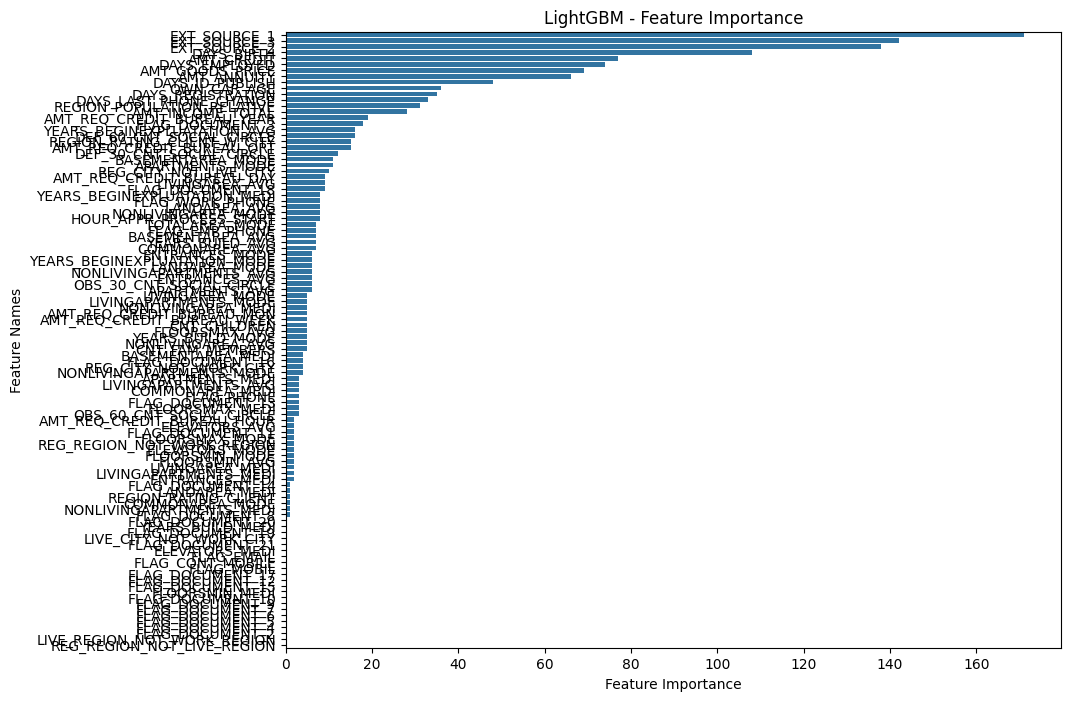

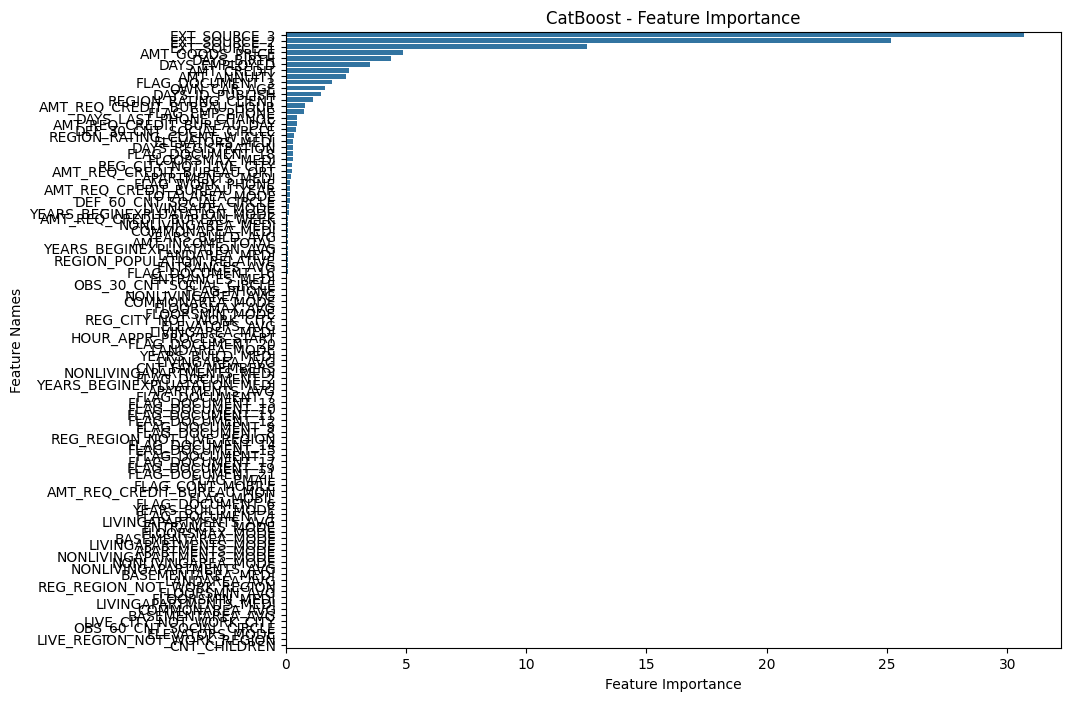

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Функция для визуализации важности признаков
def plot_feature_importance(importance, names, model_type):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.title(model_type + ' - Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

# Визуализация важности признаков для LightGBM
plot_feature_importance(lgbm_model.feature_importances_, X.columns, 'LightGBM')
plt.show()

# Визуализация важности признаков для CatBoost
plot_feature_importance(catboost_model.feature_importances_, X.columns, 'CatBoost')
plt.show()


После визуализации важности признаков вы можете определить порог и удалить неважные признаки. Например, если порог установлен на 0.05, мы можем удалить признаки, важность которых ниже этого порога, и затем переобучить модели.

In [22]:
# Порог важности, ниже которого признаки будут удалены
threshold = 0.02

# Функция для удаления неважных признаков
def remove_low_importance_features(importance, names, threshold):
    # Создание DataFrame с важностью признаков
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    fi_df = pd.DataFrame({'feature_names': feature_names, 'feature_importance': feature_importance})
    
    # Выбор признаков, важность которых выше порога
    selected_features = fi_df.loc[fi_df['feature_importance'] >= threshold, 'feature_names']
    
    # Возврат выбранных признаков
    return selected_features

# Выбор важных признаков для LightGBM
selected_features_lgbm = remove_low_importance_features(lgbm_model.feature_importances_, X.columns, threshold)

# Выбор важных признаков для CatBoost
selected_features_catboost = remove_low_importance_features(catboost_model.feature_importances_, X.columns, threshold)

# Обновление данных, оставляя только важные признаки
X_lgbm_selected = X[selected_features_lgbm]
X_catboost_selected = X[selected_features_catboost]

# Разделение данных на обучающую и тестовую выборки
X_lgbm_train_selected, X_lgbm_test_selected, Y_train, Y_test = train_test_split(X_lgbm_selected, Y, test_size=0.3, random_state=0)
X_catboost_train_selected, X_catboost_test_selected, Y_train, Y_test = train_test_split(X_catboost_selected, Y, test_size=0.3, random_state=0)
